# Compute neighbor risk

In [35]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

In [2]:
# load data
weight = pd.read_csv(
    "../../intermediate/05_spread_score.csv",
    index_col=0,
    dtype={'Resident County FIPS':str, 'Work County FIPS':str},
)

In [3]:
# preprocess drop the flow from place A to itself
weight = weight[weight['Resident County FIPS'] != weight['Work County FIPS']]

In [4]:
# load data
usafacts = pd.read_csv("../../data/usafacts/confirmed_cases.csv", dtype={'countyFIPS':str})

In [5]:
# preprocess drop rows with countyFIPS 0 and select some cols
usafacts['countyFIPS'] = usafacts['countyFIPS'].str.zfill(5)
usafacts = usafacts[usafacts['countyFIPS'] != '00000']
data = usafacts.drop(['County Name', 'State', 'stateFIPS'],axis=1)
# make sure the data is monotonic
for col_ind in reversed(range(1, data.shape[1] - 1)):
    data.iloc[:, col_ind] = np.minimum(data.iloc[:, col_ind], data.iloc[:, col_ind+1])
data.columns = ['countyFIPS'] + ['Cases_' + datetime.strptime(x, '%m/%d/%y').strftime('%m-%d-%Y') for x in data.columns[1:]]

In [6]:
# preprocess to long format
long = pd.wide_to_long(data, stubnames='Cases', i='countyFIPS', j='Date', sep='_', suffix='.*').reset_index()

In [7]:
# compute the score
neighbor_risk = long.merge(
    weight,
    left_on='countyFIPS',
    right_on='Resident County FIPS',
).drop(
    ['countyFIPS', 'Resident County FIPS'], axis=1
).assign(
    raw_weight=lambda x: x['Cases'] * x['raw_weight'],
    work_weight=lambda x: x['Cases'] * x['work_weight'],
    resident_weight=lambda x: x['Cases'] * x['resident_weight'],
).groupby(['Work County FIPS', 'Date']).agg({
    'raw_weight': np.sum,
    'resident_weight': np.sum,
    'work_weight': np.sum,
}).reset_index()


In [86]:
# preprocess long to wide
neighbor_risk_raw = neighbor_risk[
    ['Work County FIPS', 'Date', 'raw_weight']
].pivot(
    index='Work County FIPS',
    columns='Date',
    values='raw_weight',
).reset_index()
neighbor_risk_raw.columns = ['countyFIPS'] + list(neighbor_risk_raw.columns[1:])

        County Name State countyFIPS
3093  Nevada County    CA      06057


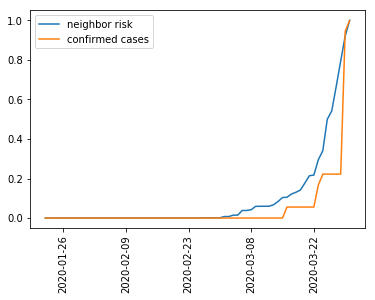

In [91]:
# visualize the raw_risk and the confirmed cases at some county
fips = usafacts.loc[usafacts['County Name'] == 'Nevada County', 'countyFIPS'].iloc[1]
print(usafacts.loc[usafacts['countyFIPS'] == fips, ['County Name', 'State', 'countyFIPS']])
fips_risk = neighbor_risk_raw[neighbor_risk_raw['countyFIPS'] == fips].iloc[:,1:].T
plt.plot(
    [datetime.strptime(x, '%m-%d-%Y') for x in fips_risk.index],
    fips_risk.values / np.max(fips_risk.values),
)
fips_confirmed = usafacts[usafacts['countyFIPS'] == fips].iloc[:, 4:].T
plt.plot(
    [datetime.strptime(x, '%m/%d/%y') for x in fips_confirmed.index],
    fips_confirmed.values / np.max(fips_confirmed.values),
)
plt.xticks(rotation=90)
plt.legend(['neighbor risk', 'confirmed cases'])
plt.show()

In [93]:
# save data
neighbor_risk_raw.to_csv("../../intermediate/06_neighbor_risk_raw.csv", index=False)